COMP532 - Machine Learning and BioInspired Optimisation - Assignment 2


*   Sam Nuttall - 201608203
*   Alina Alimova - 201588124
*   Defne Yenidunya - 201854959



In [ ]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.5 MB/s eta 0:00:00


In [ ]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379364 sha256=91474ab48820a50fcd176c0b144e6082c92dc6a9febdc6b5f1f2aeed9888c915
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


- Importing all of the needed libraries, including gymnasium, numpy, torch and matplotlib. Aswell as moviepy for making the render.

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import random
from collections import deque
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import moviepy.editor as mpy

  if event.key is 'enter':



- Create an environment of the Lunar Lander gymnasium with the default values for each attribute


In [ ]:
env = gym.make(
    "LunarLander-v3",
    continuous=False,
    gravity=-10.0,
    enable_wind=False,
    wind_power=15.0,
    turbulence_power=1.5)

- Check the action space and observation space is as listed in the gymnasium documentation

In [ ]:
env.action_space

Discrete(4)

In [ ]:
env.observation_space

Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)

First, We set up the environment to play 100 randomised episodes of play.<br><br>
For each episode of play, we reset the environment to get back to a new initial state and we set the reward to 0.<br><br>
We select a random action from the action space and then calculate the next state, the reward gained from that action, and whether the environment is terminated (based on success or failure) or truncated (due to time limit).<br><br>
We add the total score for each episode to a list in order to allow for minimum, maximum and average score display.<br><br>
Due to the use of randomised actions, there is only exploration and no exploitation, so the scores are completely random and expectedly bad.

In [ ]:
episodes = 100
scores = []

for ep in range(episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = env.action_space.sample()      # random action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state

    scores.append(total_reward)

print("min score:", min(scores))
print("avg score:", np.mean(scores))
print("max score:", max(scores))


min score: -547.5460697294179
avg score: -190.9895270135165
max score: 31.379662978024186


- Creating a Deep Q-Network with 3 fully connected layers.

- We pass the input through the 2 hidden layers with ReLU activations in the Forward( ) function.

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x) # Returns the Q-values for each action


- Creates a replay buffer which stores the buffer of the most recent state, action and rewards.
- The buffer has a maximum buffer size which it will stick within, removing the oldest ones once the buffer size is reached.
- Buffer has hyper parameters listed below...

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

#Hyperparameters
state_dim = env.observation_space.shape[0] #8-dimensional state vector
action_dim = env.action_space.n #4 discrete actions
buffer_size = 100000 #Replay buffer capacity, 100000 transitions
batch_size = 64 #Batch size for learning
gamma = 0.99 #Discount factor
lr = 1e-3 #Learning rate for network
eps_start = 1.0 #Initial exploration probability
eps_end = 0.01 #Final minimum exploration
eps_decay = 0.995 #decay per episode
target_update_freq = 10 #Update target network every 10 episodes

#Instantiate network
policy_net = DQN(state_dim, action_dim).cuda()
target_net = DQN(state_dim, action_dim).cuda()
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = ReplayBuffer(buffer_size)


The following section is the main training loop.<br><br>
It loops for 1000 episodes, using epsilon-greedy actions.<br><br>
At each step the transitions are stored upto the buffer capacity.

In [ ]:
rewards_history = []
loss_history = []
epsilon = eps_start

for ep in range(1, 1001): #Loop for 1000 episodes
    state, _ = env.reset()#Reset the environment state for each episode
    state = np.array(state)
    total_reward = 0 #reset the reward for each episode
    done = False

    while not done:
        #Select action (epsilon-greedy)
        #with probability epsilon we explore by sampling a random action, otherwise we exploit the best known actions upto that point.
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                s = torch.FloatTensor(state).unsqueeze(0).cuda()
                q = policy_net(s)
                action = q.argmax().item()

        #Step with that action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.push(state, action, reward, next_state, done)
        state = next_state #moves the state to the next state and sums the reward
        total_reward += reward

        #Learning routine
        if len(memory) >= batch_size: #We wait until the replay buffer has at least batch_size experiences before we do any learning.
            states, actions, rewards, next_states, dones = memory.sample(batch_size)

            #Convert NumPy arrays to torch tensors on the GPU
            states = torch.FloatTensor(states).cuda()
            actions = torch.LongTensor(actions).unsqueeze(1).cuda()
            rewards = torch.FloatTensor(rewards).unsqueeze(1).cuda()
            next_states = torch.FloatTensor(next_states).cuda()
            dones = torch.FloatTensor(dones).unsqueeze(1).cuda()

            #Current Q
            curr_q = policy_net(states).gather(1, actions)
            #Target Q
            next_q = target_net(next_states).max(1)[0].unsqueeze(1)
            expected_q = rewards + gamma * next_q * (1 - dones)

            loss = nn.functional.mse_loss(curr_q, expected_q.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())

    #Record values and decay the exploration rate (epslion)
    rewards_history.append(total_reward)
    epsilon = max(eps_end, epsilon * eps_decay)

    if ep % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {ep} --- Reward: {total_reward:.1f} --- Epsilon: {epsilon:.2f}") #Print out the reward and epsilon value for each episode


Episode 1 --- Reward: -15.2 --- Epsilon: 0.99
Episode 2 --- Reward: -205.8 --- Epsilon: 0.99
Episode 3 --- Reward: -160.6 --- Epsilon: 0.99
Episode 4 --- Reward: -189.7 --- Epsilon: 0.98
Episode 5 --- Reward: -87.3 --- Epsilon: 0.98
Episode 6 --- Reward: -292.6 --- Epsilon: 0.97
Episode 7 --- Reward: -124.2 --- Epsilon: 0.97
Episode 8 --- Reward: -122.1 --- Epsilon: 0.96
Episode 9 --- Reward: -119.5 --- Epsilon: 0.96
Episode 10 --- Reward: -220.7 --- Epsilon: 0.95
Episode 11 --- Reward: -76.5 --- Epsilon: 0.95
Episode 12 --- Reward: -89.7 --- Epsilon: 0.94
Episode 13 --- Reward: -72.2 --- Epsilon: 0.94
Episode 14 --- Reward: -129.7 --- Epsilon: 0.93
Episode 15 --- Reward: -244.0 --- Epsilon: 0.93
Episode 16 --- Reward: -76.5 --- Epsilon: 0.92
Episode 17 --- Reward: -94.5 --- Epsilon: 0.92
Episode 18 --- Reward: -88.4 --- Epsilon: 0.91
Episode 19 --- Reward: -130.8 --- Epsilon: 0.91
Episode 20 --- Reward: -81.5 --- Epsilon: 0.90
Episode 21 --- Reward: -106.6 --- Epsilon: 0.90
Episode 22

Next, we plotted the total rewards against the number of episodes to see how the training improves total rewards - and we also plotted the MSE loss against the training steps.

<br><br>

We can see from the plots that the rewards get larger as the model trains more and that the training stabilises as the environment steps.

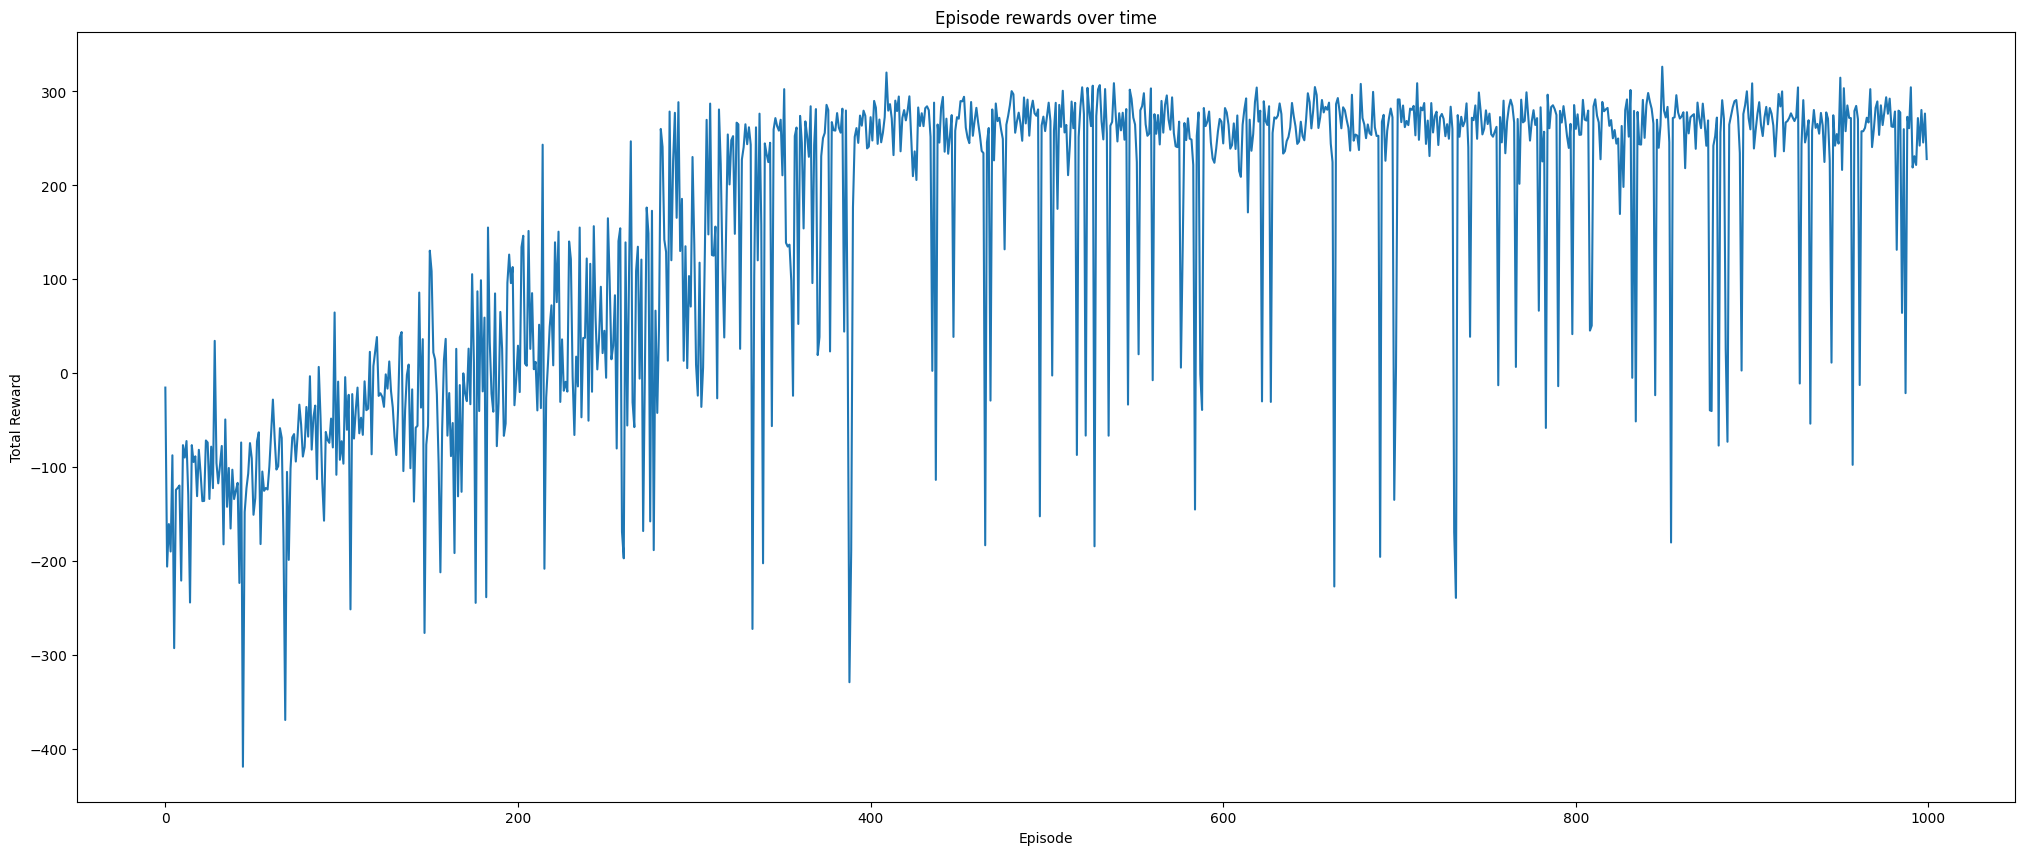

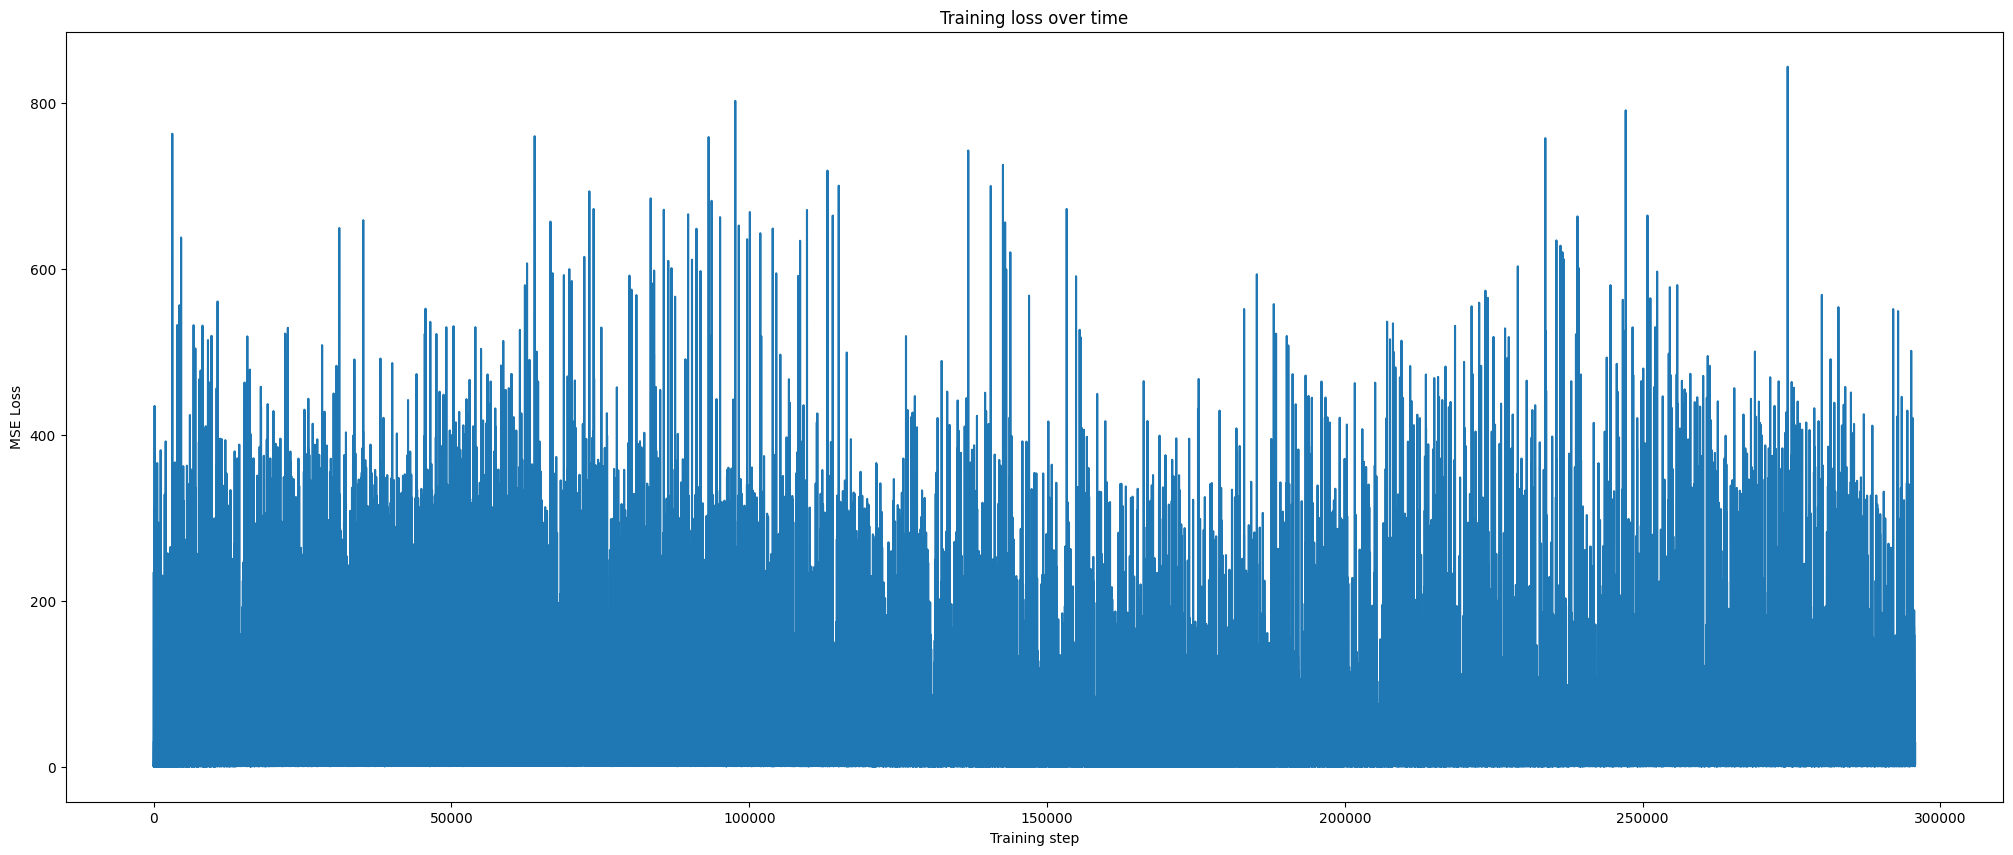

In [ ]:
#Plot Rewards against Episodes on graph using matplotolib
plt.figure(figsize=(25,10))
plt.plot(rewards_history)
plt.title("Episode rewards over time")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

print('')

#Plot Loss against training steps
plt.figure(figsize=(25,10))
plt.plot(loss_history)
plt.title("Training loss over time")
plt.xlabel("Training step")
plt.ylabel("MSE Loss")
plt.show()


This code is used to generate an Mp4 and a GIF file to show the render of how the environment works. It uses moviePy.<br><br>
We create a new environment with a rgb render mode so that it can generate frames which can be made into the video file.

In [ ]:
video_env = gym.make("LunarLander-v3", render_mode="rgb_array", continuous=False, gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5)

frames = []
state, _ = video_env.reset()
state = np.array(state)
done = False

while not done:
    frame = video_env.render()
    frames.append(frame)

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).cuda()
        action = policy_net(s).argmax().item()

    next_state, _, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated
    state = np.array(next_state)

video_env.close()

clip = mpy.ImageSequenceClip(frames, fps=30)
clip.write_videofile("lunar_lander_agent.mp4", codec="libx264")
clip.write_gif("lunar_lander_agent.gif", fps=30)



Moviepy - Building video lunar_lander_agent.mp4.
Moviepy - Writing video lunar_lander_agent.mp4



Moviepy - Done !
Moviepy - video ready lunar_lander_agent.mp4
MoviePy - Building file lunar_lander_agent.gif with imageio.
